In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Synthetic Dataset

- z ~ N(0, I) 
- x = 10 + z^3 (Invertible DGP)
- y = I( Sum_{i}(z_{i}) > 0 ) (True Prediction Function)

The marginal distribution p(z_{i}) will be normal distribution (z is multivariate normal); therefore sum over z_{i} would be gaussian distribution with zero mean

In [2]:
data_dim= 2
num_classes= 2
train_size= 500
test_size= 100

## Data Generation

In [3]:
# Sample z from multivariate normal distribution
train_z= np.random.multivariate_normal(np.zeros(data_dim), np.eye(data_dim), train_size)
test_z= np.random.multivariate_normal(np.zeros(data_dim), np.eye(data_dim), test_size)

In [4]:
# Sample x and y conditioned on the true latent z
train_x=  0.1 + (train_z)**3
train_y= 1*(np.sum(train_z, axis=1) > 0)

test_x= 0.1 + (test_z)**3
test_y= 1*(np.sum(test_z, axis=1) > 0)

Text(0, 0.5, 'Class Label y')

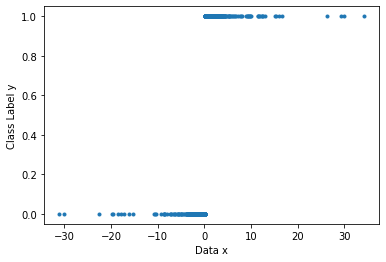

In [5]:
plt.plot(np.sum(train_x, axis=1), train_y, '.')
# plt.xlabel('Latent z')
plt.xlabel('Data x')
plt.ylabel('Class Label y')

## Model Architecture

In [6]:
# Defining the fully connected network
class FC(torch.nn.Module):          
     
    def __init__(self, inp_dim, classes):     
        super(FC, self).__init__()
                
        self.inp_dim= inp_dim
        self.classes= classes
        self.rep_net= nn.Sequential(                    
                    nn.Linear(inp_dim, inp_dim),
                    nn.ReLU(),
                    nn.Linear(inp_dim, inp_dim),
        )
        
        self.fc_net= nn.Sequential(                    
                    nn.Linear(inp_dim, classes)
        )
        
        
    def forward(self, x):        
        out= self.rep_net(x)
        out= self.fc_net(out)
        return out

In [7]:
model= FC(data_dim, num_classes)
print(model)

FC(
  (rep_net): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
)


## Training the model

In [8]:
batch_size= 16
lr= 0.01
num_epochs= 20
opt= optim.SGD([
                {'params': filter(lambda p: p.requires_grad, model.parameters()) }, 
                ], lr= lr, weight_decay= 5e-4, momentum= 0.9,  nesterov=True ) 

In [9]:
# Partition into batches
train_split_x= np.array_split( train_x, train_x.shape[0]//batch_size ,axis=0 )
train_split_y= np.array_split( train_y, train_y.shape[0]//batch_size ,axis=0 )
total_batches= len(train_split_x)

In [10]:
for epoch in range(num_epochs):
    train_loss= 0.0
    train_acc= 0.0
    for batch_num in range(total_batches):
        
        
        batch_x= torch.tensor( train_split_x[batch_num] ).float()
        batch_y= torch.tensor( train_split_y[batch_num] ).long()
        
        #Forward Pass
        out= model(batch_x)
        loss= F.cross_entropy(out, batch_y)
        
        #Backward Pass
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        #Logging
        train_loss+= loss.item()
        train_acc+= torch.sum( torch.argmax(out, dim=1) == batch_y ).item()
        
    print('Epoch: ', epoch)
    print('Train Loss: ', train_loss/total_batches)
    print('Train Accuracy: ', 100*train_acc/train_size)

Epoch:  0
Train Loss:  0.5771851308884159
Train Accuracy:  71.6
Epoch:  1
Train Loss:  0.34377051745691606
Train Accuracy:  86.8
Epoch:  2
Train Loss:  0.2205292249639188
Train Accuracy:  92.8
Epoch:  3
Train Loss:  0.15799623529516882
Train Accuracy:  96.0
Epoch:  4
Train Loss:  0.13379026781166753
Train Accuracy:  96.0
Epoch:  5
Train Loss:  0.12033282526798787
Train Accuracy:  95.6
Epoch:  6
Train Loss:  0.11090497239943474
Train Accuracy:  95.6
Epoch:  7
Train Loss:  0.10370356711228529
Train Accuracy:  95.6
Epoch:  8
Train Loss:  0.09792347724038747
Train Accuracy:  95.6
Epoch:  9
Train Loss:  0.09313418083043108
Train Accuracy:  95.6
Epoch:  10
Train Loss:  0.08907812860824409
Train Accuracy:  95.6
Epoch:  11
Train Loss:  0.08556651215129081
Train Accuracy:  95.6
Epoch:  12
Train Loss:  0.08248542084343612
Train Accuracy:  95.6
Epoch:  13
Train Loss:  0.07975484424030348
Train Accuracy:  95.8
Epoch:  14
Train Loss:  0.0773077646548289
Train Accuracy:  95.8
Epoch:  15
Train Loss: 

## Evaluate the model

In [11]:
model.eval()

FC(
  (rep_net): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [12]:
# Partition into batches
test_split_x= np.array_split( test_x, test_x.shape[0]//batch_size ,axis=0 )
test_split_y= np.array_split( test_y, test_y.shape[0]//batch_size ,axis=0 )
total_batches= len(test_split_x)

### Test Accuracy

In [13]:
with torch.no_grad():
    
    test_acc= 0.0
    for batch_num in range(total_batches):
        
        batch_x= torch.tensor( test_split_x[batch_num] ).float()
        batch_y= torch.tensor( test_split_y[batch_num] ).long()
        
        #Forward Pass
        out= model(batch_x)
                
        #Logging
        test_acc+= torch.sum( torch.argmax(out, dim=1) == batch_y ).item()
        
print('Test Accuracy: ', 100*test_acc/test_size)

Test Accuracy:  99.0


### Correlation between (true, predicted) latent

In [14]:
pred_latent= []
with torch.no_grad():
    for batch_num in range(total_batches):
        
        batch_x= torch.tensor( test_split_x[batch_num] ).float()        
        rep= model.rep_net(batch_x)
        pred_latent.append(rep)    

pred_latent= np.concatenate(pred_latent)

In [15]:
from sklearn.cross_decomposition import CCA
cca= CCA(n_components=1)
cca.fit(pred_latent, test_z)
X_c, Y_c = cca.transform(pred_latent, test_z)
stats.pearsonr(X_c[:, 0], Y_c[:, 0])

(0.8643226676194318, 5.193679616635632e-31)